## Estimate the steady-state of the number of available bikes in a CitiBike station using Markov chains 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
Julyrides_df = pd.read_pickle('preprocessed_julyrides.pkl')

# Filter for weekdays
Julyrides_weekdays = Julyrides_df[Julyrides_df['started_at'].dt.weekday < 5].copy()

# Extract hour from started_at column to filter for morning and evening rush hour
Julyrides_weekdays['hour'] = Julyrides_weekdays['started_at'].dt.hour

# Define morning and evening rush hour filters and combine
morning_rushhour_rides = Julyrides_weekdays[Julyrides_weekdays['hour'].isin([7, 8, 9])].copy()
evening_rushhour_rides = Julyrides_weekdays[Julyrides_weekdays['hour'].isin([17, 18, 19])].copy()
combined_rushhour_rides = pd.concat([morning_rushhour_rides, evening_rushhour_rides])

# Function to identify top 3 stations in terms of number of rides during morning and evening rush hour
def display_top_stations(rides_df, morning_rides_df, evening_rides_df):
    departures = rides_df['start_station_id'].value_counts()
    arrivals = rides_df['end_station_id'].value_counts()
    
    total_traffic = departures.add(arrivals, fill_value=0)
    
    top_3_stations = total_traffic.nlargest(3)

    print("=" * 105)
    print(f"Top 3 citibike stations")
    print("=" * 105)
    print()
    print(f"{'Station ID':<15} {'Station Name':<25} {'Total':>8} {'Morn Dep':>10} {'Morn Arr':>10} {'Eve Dep':>10} {'Eve Arr':>10}")
    print("-" * 105)
    
    if 'start_station_name' in rides_df.columns:
        for station_id in top_3_stations.index:
            station_name = rides_df[rides_df['start_station_id'] == station_id]['start_station_name'].iloc[0]
            num_rides = int(total_traffic[station_id])
            
            # Calculate morning departures and arrivals
            morning_departure = morning_rides_df[morning_rides_df['start_station_id'] == station_id].shape[0]
            morning_arrival = morning_rides_df[morning_rides_df['end_station_id'] == station_id].shape[0]

            # Calculate evening departures and arrivals
            evening_departure = evening_rides_df[evening_rides_df['start_station_id'] == station_id].shape[0]
            evening_arrival = evening_rides_df[evening_rides_df['end_station_id'] == station_id].shape[0]

            print(f"{station_id:<15} {station_name:<25} {num_rides:>8,} {morning_departure:>10,} {morning_arrival:>10,} {evening_departure:>10,} {evening_arrival:>10,}")
    
    print("-" * 105)
    print()
    
    return top_3_stations

top_3_combined = display_top_stations(combined_rushhour_rides, morning_rushhour_rides, evening_rushhour_rides)

Top 3 citibike stations

Station ID      Station Name                 Total   Morn Dep   Morn Arr    Eve Dep    Eve Arr
---------------------------------------------------------------------------------------------------------
5329.03         West St & Chambers St       12,940      2,086      2,625      4,306      3,923
6492.08         9 Ave & W 33 St             12,766      1,947      4,495      4,189      2,135
6140.05         W 21 St & 6 Ave             12,714      2,265      3,299      4,010      3,140
---------------------------------------------------------------------------------------------------------



In [15]:
# Discretize morning and evening rush hours into 5 minute intervals
Interval = 5

# Create minute of day for binning rush hour rides
combined_rushhour_rides['minute_of_day'] = (
    combined_rushhour_rides['started_at'].dt.hour * 60 + 
    combined_rushhour_rides['started_at'].dt.minute
)

# Create combined bins for both morning and evening rush hour
morning_bins = np.arange(7*60, 10*60 + Interval, Interval)
evening_bins = np.arange(17*60, 20*60 + Interval, Interval)
combined_bins = sorted(set(list(morning_bins) + list(evening_bins)))

# Apply time_interval binning to combined_rushhour_rides
combined_rushhour_rides['time_interval'] = pd.cut(
    combined_rushhour_rides['minute_of_day'],
    bins=combined_bins,
    labels=range(len(combined_bins) - 1),
    include_lowest=True
)

### Set fixed starting inventory and capacity based on citibike map data

In [ ]:
# Set fixed starting inventory and capacity based on citibike map data
starting_inventory = 0.50

# Hardcoded capacities for 3 stations with most total traffic during morning and evening rush hours
max_capacities = {'6140.05': 42, '6492.08': 63, '5329.03': 64}

# Station name mapping
station_names = {
    '6140.05': 'W 21 St & 6 Ave',
    '6492.08': '9 Ave & W 33 St', 
    '5329.03': 'West St & Chambers St'
}

def solve_steady_state(matrix):
    # Calculate steady state distribution by iterating matrix multiplication
    state = np.ones(len(matrix)) / len(matrix)
    for _ in range(1000):
        state = state @ matrix
    return state

def get_transition_matrix(df, station_id, capacity, hour_range):
    # Build transition matrix with fixed starting inventory
    subset = df[
        ((df['start_station_id'] == station_id) | (df['end_station_id'] == station_id)) & 
        (df['started_at'].dt.hour.isin(hour_range))
    ].copy()
    
    n_states = capacity + 1
    
    if subset.empty:
        return np.eye(n_states)

    counts = np.zeros((n_states, n_states))
    
    fixed_starting_inventory = int(capacity * starting_inventory)

    for date in subset['started_at'].dt.date.unique():
        current_bikes = fixed_starting_inventory

        day_data = subset[subset['started_at'].dt.date == date]
        
        # Track flow through the time intervals
        unique_intervals = sorted(day_data['time_interval'].unique())
        for i in unique_intervals:
            flow = day_data[day_data['time_interval'] == i]
            arrivals = len(flow[flow['end_station_id'] == station_id])
            departures = len(flow[flow['start_station_id'] == station_id])
            
            # Determine next state
            next_bikes = current_bikes + arrivals - departures
            next_bikes = max(0, min(capacity, next_bikes))
            
            counts[current_bikes, next_bikes] += 1
            
            current_bikes = next_bikes

    # Normalize counts to probabilities
    matrix = np.zeros((n_states, n_states))
    for i in range(n_states):
        total = counts[i].sum()
        if total > 0:
            matrix[i] = counts[i] / total
        else:
            matrix[i, i] = 1 
            
    return matrix

# Getting transition matrix and steady state for each station
print(f"Running model with fixed starting inventory: {starting_inventory*100}% Full")
print(f"{'Station Name':<30} | {'Time':<10} | {'Exp. Bikes':<10} | {'Prob. Empty':<12} | {'Prob. Full':<10}")
print("-" * 90)

for station_id in top_3_combined.index:
    capacity = max_capacities[station_id]
    station_name = station_names.get(station_id, station_id)
    
    # Morning
    morning_matrix = get_transition_matrix(combined_rushhour_rides, station_id, capacity, [7, 8, 9])
    morning_steady = solve_steady_state(morning_matrix)
    morning_expected = np.sum(morning_steady * np.arange(capacity + 1))

    # Evening
    evening_matrix = get_transition_matrix(combined_rushhour_rides, station_id, capacity, [17, 18, 19])
    evening_steady = solve_steady_state(evening_matrix)
    evening_expected = np.sum(evening_steady * np.arange(capacity + 1))

    print(f"{station_name:<30} | Morning    | {morning_expected:5.1f}      | {morning_steady[0]:5.1%}       | {morning_steady[-1]:5.1%}")
    print(f"{'':30} | Evening    | {evening_expected:5.1f}      | {evening_steady[0]:5.1%}       | {evening_steady[-1]:5.1%}")
    print("-" * 90)

Running model with fixed starting inventory: 50.0% Full
Station Name                   | Time       | Exp. Bikes | Prob. Empty  | Prob. Full
------------------------------------------------------------------------------------------
West St & Chambers St          | Morning    |  43.7      |  1.5%       | 18.1%
                               | Evening    |  18.3      | 20.3%       |  1.5%
------------------------------------------------------------------------------------------
9 Ave & W 33 St                | Morning    |  40.6      |  1.6%       | 47.7%
                               | Evening    |  23.2      | 28.3%       |  1.6%
------------------------------------------------------------------------------------------
W 21 St & 6 Ave                | Morning    |  28.5      |  2.3%       | 34.0%
                               | Evening    |  10.7      | 33.7%       |  2.3%
------------------------------------------------------------------------------------------


### Using more rubust bootstrapping simulation approach

In [17]:
def get_transition_matrix_bootstrapped(df, station_id, capacity, hour_range):
    # Build transition matrix using bootstrapping with multiple starting capacity scenarios
    subset = df[
        ((df['start_station_id'] == station_id) | (df['end_station_id'] == station_id)) & 
        (df['started_at'].dt.hour.isin(hour_range))
    ].copy()
    
    n_states = capacity + 1
    counts = np.zeros((n_states, n_states))
    
    # Define bootstrapping scenarios
    start_inventories = [0.1, 0.3, 0.5, 0.7, 0.9]

    # Loop through each hypothetical starting scenario
    for inventory in start_inventories:
        initial_bikes = int(capacity * inventory)

        for date in subset['started_at'].dt.date.unique():
            current_bikes = initial_bikes
            
            day_data = subset[subset['started_at'].dt.date == date]
            
            unique_intervals = sorted(day_data['time_interval'].unique())
            
            for i in unique_intervals:
                # Calculate net flow using 'time_interval'
                flow = day_data[day_data['time_interval'] == i]
                
                arrivals = len(flow[flow['end_station_id'] == station_id])
                departures = len(flow[flow['start_station_id'] == station_id])
                
                next_bikes = current_bikes + arrivals - departures
                next_bikes = max(0, min(capacity, next_bikes))
                
                counts[current_bikes, next_bikes] += 1
                current_bikes = next_bikes

    # Normalize counts to probabilities
    matrix = np.zeros((n_states, n_states))
    for i in range(n_states):
        total = counts[i].sum()
        if total > 0:
            matrix[i] = counts[i] / total
        else:
            matrix[i, i] = 1
            
    return matrix

print(f"Running Model with Bootstrapping (5 starting scenarios)")
print(f"{'Station Name':<30} | {'Time':<10} | {'Exp. Bikes':<10} | {'Prob. Empty':<12} | {'Prob. Full':<10}")
print("-" * 90)

for station_id in top_3_combined.index:
    capacity = max_capacities[station_id]
    station_name = station_names.get(station_id, station_id)
    
    # Morning
    morning_matrix = get_transition_matrix_bootstrapped(combined_rushhour_rides, station_id, capacity, [7, 8, 9])
    morning_steady = solve_steady_state(morning_matrix)
    morning_expected = np.sum(morning_steady * np.arange(capacity + 1))

    # Evening
    evening_matrix = get_transition_matrix_bootstrapped(combined_rushhour_rides, station_id, capacity, [17, 18, 19])
    evening_steady = solve_steady_state(evening_matrix)
    evening_expected = np.sum(evening_steady * np.arange(capacity + 1))
    
    print(f"{station_name:<30} | Morning    | {morning_expected:5.1f}      | {morning_steady[0]:5.1%}       | {morning_steady[-1]:5.1%}")
    print(f"{'':30} | Evening    | {evening_expected:5.1f}      | {evening_steady[0]:5.1%}       | {evening_steady[-1]:5.1%}")
    print("-" * 90)

Running Model with Bootstrapping (5 starting scenarios)
Station Name                   | Time       | Exp. Bikes | Prob. Empty  | Prob. Full
------------------------------------------------------------------------------------------
West St & Chambers St          | Morning    |  60.4      |  0.0%       | 31.6%
                               | Evening    |  10.1      | 20.9%       |  0.1%
------------------------------------------------------------------------------------------
9 Ave & W 33 St                | Morning    |  58.8      |  1.6%       | 80.6%
                               | Evening    |   5.4      | 49.1%       |  1.6%
------------------------------------------------------------------------------------------
W 21 St & 6 Ave                | Morning    |  40.2      |  0.0%       | 51.4%
                               | Evening    |   2.6      | 43.2%       |  0.0%
------------------------------------------------------------------------------------------


In [20]:
# Compare expected bikes at steady state for both approaches
comparison_results = {}

for station_id in top_3_combined.index:
    capacity = max_capacities[station_id]
    station_name = station_names.get(station_id, station_id)
    
    # Fixed approach (50% starting inventory)
    morning_matrix_fixed = get_transition_matrix(combined_rushhour_rides, station_id, capacity, [7, 8, 9])
    morning_steady_fixed = solve_steady_state(morning_matrix_fixed)
    morning_exp_fixed = np.sum(morning_steady_fixed * np.arange(capacity + 1))

    evening_matrix_fixed = get_transition_matrix(combined_rushhour_rides, station_id, capacity, [17, 18, 19])
    evening_steady_fixed = solve_steady_state(evening_matrix_fixed)
    evening_exp_fixed = np.sum(evening_steady_fixed * np.arange(capacity + 1))
    
    # Bootstrapped approach (multiple starting inventory scenarios)
    morning_matrix_bootstrapped = get_transition_matrix_bootstrapped(combined_rushhour_rides, station_id, capacity, [7, 8, 9])
    morning_steady_bootstrapped = solve_steady_state(morning_matrix_bootstrapped)
    morning_exp_bootstrapped = np.sum(morning_steady_bootstrapped * np.arange(capacity + 1))
    
    evening_matrix_bootstrapped = get_transition_matrix_bootstrapped(combined_rushhour_rides, station_id, capacity, [17, 18, 19])
    evening_steady_bootstrapped = solve_steady_state(evening_matrix_bootstrapped)
    evening_exp_bootstrapped = np.sum(evening_steady_bootstrapped * np.arange(capacity + 1))

    comparison_results[station_id] = {
        'name': station_name,
        'capacity': capacity,
        'morning_fixed': {'dist': morning_steady_fixed, 'exp': morning_exp_fixed},
        'morning_boot': {'dist': morning_steady_boot, 'exp': morning_exp_boot},
        'evening_fixed': {'dist': evening_steady_fixed, 'exp': evening_exp_fixed},
        'evening_boot': {'dist': evening_steady_boot, 'exp': evening_exp_boot}
    }

# Print summary table
print("\n" + "="*110)
print("Comparison of our approaches: Expected Bikes at Steady-State")
print("="*110)
print(f"{'Station':<30} | {'Period':<10} | {'Fixed 50%':<12} | {'Bootstrapped':<12} | {'Difference':<12}")
print("-"*110)

for station_id in top_3_combined.index:
    data = comparison_results[station_id]
    name = data['name']
    
    morning_diff = data['morning_boot']['exp'] - data['morning_fixed']['exp']
    evening_diff = data['evening_boot']['exp'] - data['evening_fixed']['exp']
    
    print(f"{name:<30} | Morning    | {data['morning_fixed']['exp']:>10.1f} | {data['morning_boot']['exp']:>12.1f} | {morning_diff:>+11.1f}")
    print(f"{'':30} | Evening    | {data['evening_fixed']['exp']:>10.1f} | {data['evening_boot']['exp']:>12.1f} | {evening_diff:>+11.1f}")
    print("-"*110)


Comparison of our approaches: Expected Bikes at Steady-State
Station                        | Period     | Fixed 50%    | Bootstrapped | Difference  
--------------------------------------------------------------------------------------------------------------
West St & Chambers St          | Morning    |       43.7 |         40.2 |        -3.6
                               | Evening    |       18.3 |          2.6 |       -15.7
--------------------------------------------------------------------------------------------------------------
9 Ave & W 33 St                | Morning    |       40.6 |         40.2 |        -0.5
                               | Evening    |       23.2 |          2.6 |       -20.5
--------------------------------------------------------------------------------------------------------------
W 21 St & 6 Ave                | Morning    |       28.5 |         40.2 |       +11.7
                               | Evening    |       10.7 |          2.6 |        -8.1


### Histograms showing transition matrix for stations in morning and evening

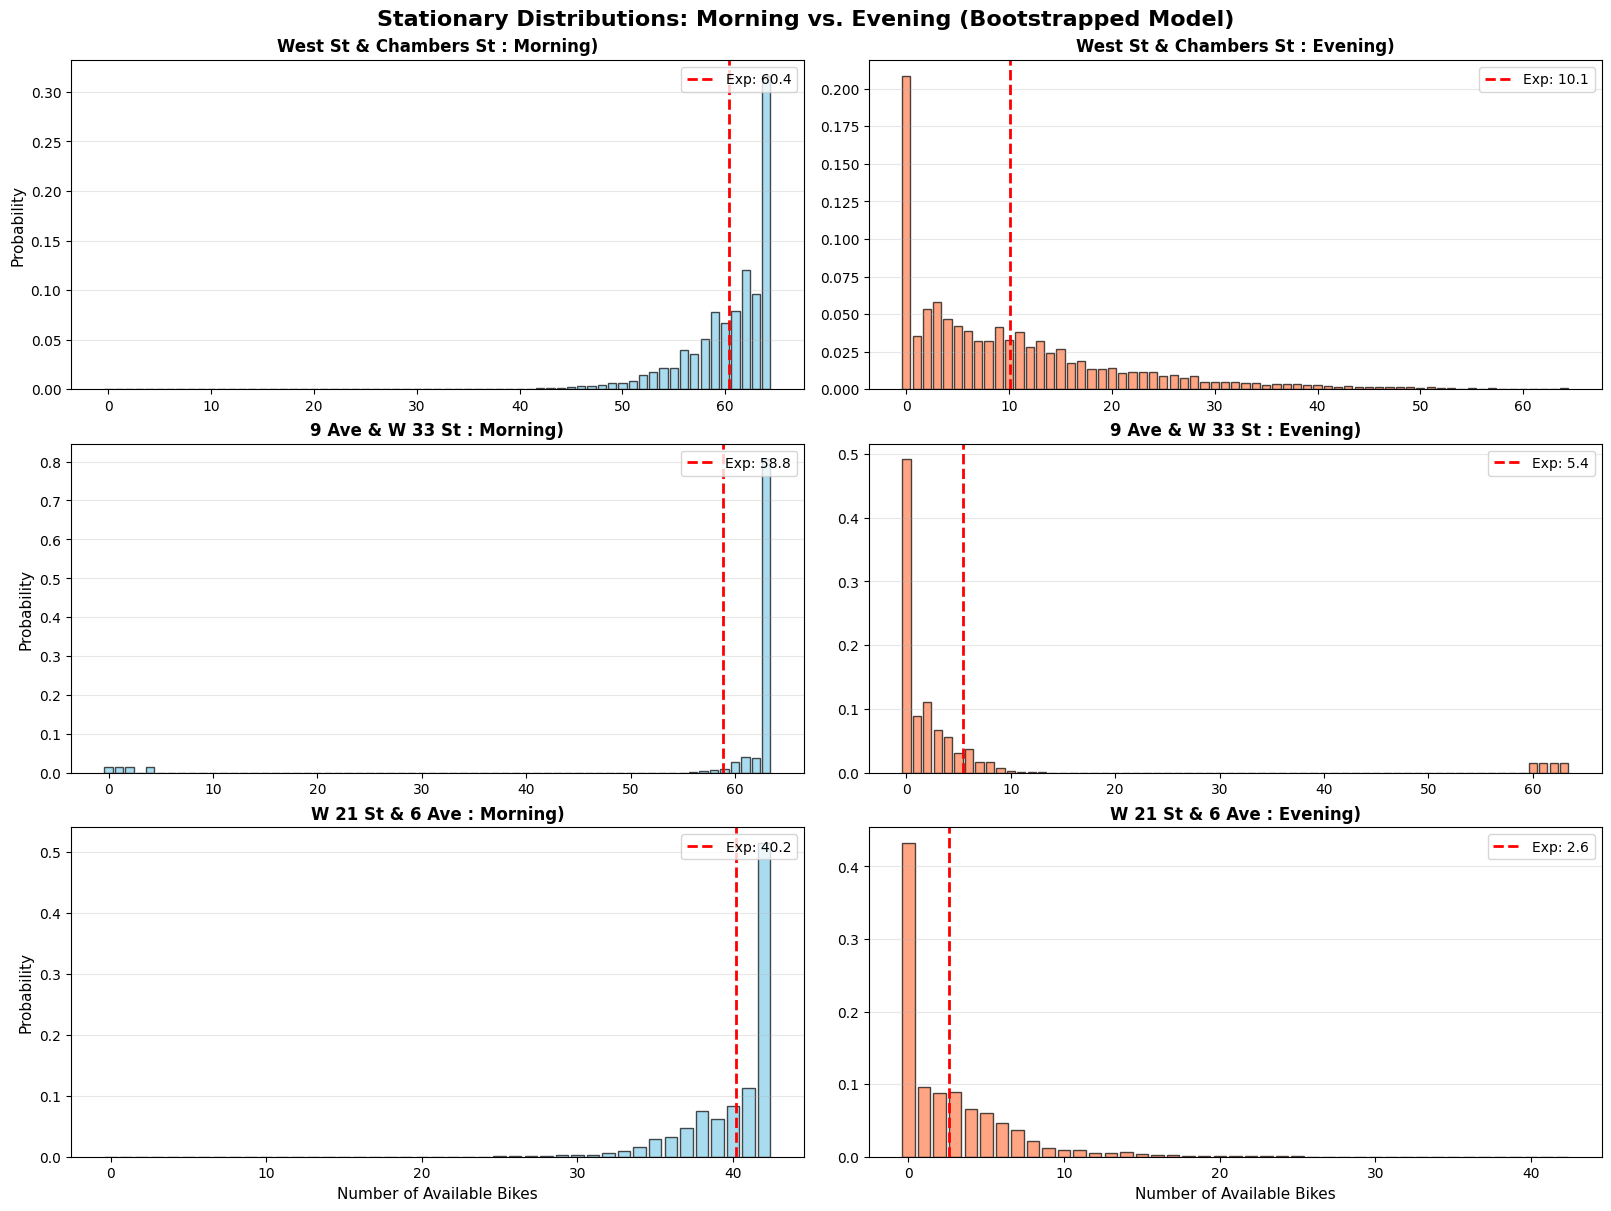

In [ ]:
# Calculate and store steady-state distributions
station_results = {}

for station_id in top_3_combined.index:
    capacity = max_capacities[station_id]
    
    # Morning
    morning_matrix = get_transition_matrix_bootstrapped(combined_rushhour_rides, station_id, capacity, [7, 8, 9])
    morning_steady = solve_steady_state(morning_matrix)
    
    # Evening
    evening_matrix = get_transition_matrix_bootstrapped(combined_rushhour_rides, station_id, capacity, [17, 18, 19])
    evening_steady = solve_steady_state(evening_matrix)
    
    station_results[station_id] = {
        'capacity': capacity,
        'morning': morning_steady,
        'evening': evening_steady
    }

# Visualize stationary distributions
fig, axes = plt.subplots(3, 2, figsize=(16, 12), constrained_layout=True)
fig.suptitle('Stationary Distributions: Morning vs. Evening (Bootstrapped Model)', 
             fontsize=16, fontweight='bold')

for idx, station_id in enumerate(top_3_combined.index):
    capacity = station_results[station_id]['capacity']
    station_name = station_names.get(station_id, f"Station {station_id}")
    states = np.arange(capacity + 1)
    
    # Morning and evening time blocks
    for col, time_block in enumerate(['morning', 'evening']):
        ax = axes[idx, col]
        dist = station_results[station_id][time_block]
        color = 'skyblue' if time_block == 'morning' else 'coral'
        
        # Plot distribution
        ax.bar(states, dist, color=color, edgecolor='black', alpha=0.7)
        
        # Add expected value line
        expected_bikes = np.sum(states * dist)
        ax.axvline(expected_bikes, color='red', linestyle='--', linewidth=2, 
                   label=f'Exp: {expected_bikes:.1f}')
        
        ax.set_title(f'{station_name} : {time_block.capitalize()}', 
                    fontsize=12, fontweight='bold')
        ax.legend(loc='upper right')
        ax.grid(axis='y', alpha=0.3)
        
        if col == 0:
            ax.set_ylabel('Probability', fontsize=11)
        
        if idx == len(top_3_combined.index) - 1:
            ax.set_xlabel('Number of Available Bikes', fontsize=11)

plt.show()

## Validation: Emprical data vs Markov Model Predictions

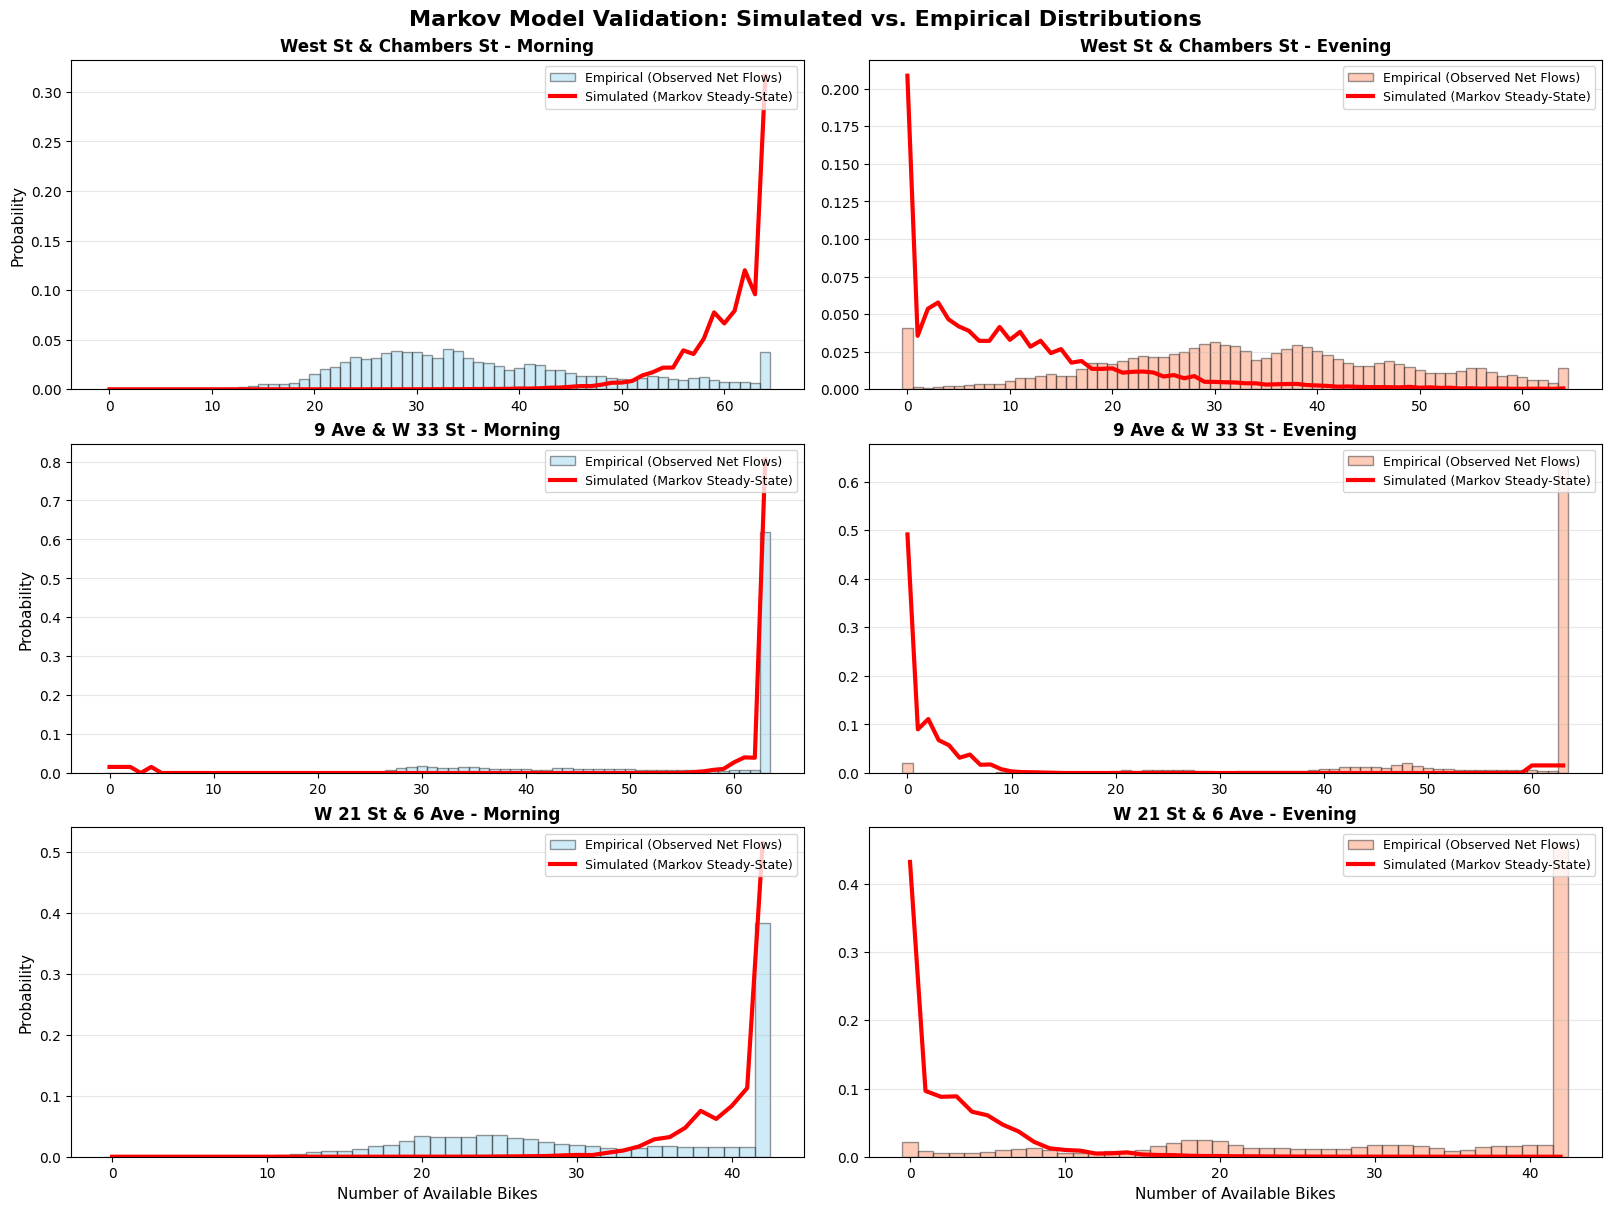

In [37]:
def get_empirical_distribution(rides_df, station_id, capacity, hour_range):
    # Filter for station transactions
    station_mask = ((rides_df['start_station_id'] == station_id) | 
                    (rides_df['end_station_id'] == station_id))
    subset = rides_df[station_mask].copy()
    
    # Track departures and arrivals
    departures = subset[subset['start_station_id'] == station_id][['started_at']].copy()
    departures.columns = ['time']
    departures['change'] = -1
    
    arrivals = subset[subset['end_station_id'] == station_id][['ended_at']].copy()
    arrivals.columns = ['time']
    arrivals['change'] = 1
    
    # Combine and sort chronologically
    timeline = pd.concat([departures, arrivals]).sort_values('time')
    timeline['date'] = timeline['time'].dt.date
    
    empirical_counts = []
    
    # Process each day independently
    for date, day_data in timeline.groupby('date'):
        current_bikes = capacity // 2
        
        day_data = day_data.sort_values('time')
        day_data['inventory'] = (day_data['change'].cumsum() + current_bikes).clip(0, capacity)
        
        # Extract inventory states during rush hour
        rush_hour_mask = day_data['time'].dt.hour.isin(hour_range)
        empirical_counts.extend(day_data.loc[rush_hour_mask, 'inventory'].tolist())
    
    return empirical_counts

# Compare simulated vs empirical distributions
fig, axes = plt.subplots(3, 2, figsize=(16, 12), constrained_layout=True)
fig.suptitle('Markov Model Validation: Simulated vs. Empirical Distributions', 
             fontsize=16, fontweight='bold')

for idx, station_id in enumerate(top_3_combined.index):
    capacity = max_capacities[station_id]
    station_name = station_names.get(station_id, f"Station {station_id}")
    
    # Morning and evening time blocks
    for col, (time_block, hour_range) in enumerate([('morning', [7, 8, 9]), ('evening', [17, 18, 19])]):
        ax = axes[idx, col]
        color = 'skyblue' if col == 0 else 'coral'
        
        # Get empirical distribution
        empirical_counts = get_empirical_distribution(combined_rushhour_rides, station_id, capacity, hour_range)
        
        if empirical_counts:
            # Plot empirical histogram
            ax.hist(empirical_counts, bins=np.arange(0, capacity+2)-0.5, 
                   density=True, alpha=0.4, color=color, 
                   label='Empirical (Observed Net Flows)', edgecolor='black')
            
            # Plot simulated steady-state
            simulated_dist = station_results[station_id][time_block]
            ax.plot(range(len(simulated_dist)), simulated_dist, 
                   color='red', linewidth=3, label='Simulated (Markov Steady-State)')
        
        ax.set_title(f'{station_name} - {time_block.capitalize()}', 
                    fontsize=12, fontweight='bold')
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(axis='y', alpha=0.3)
        
        if col == 0:
            ax.set_ylabel('Probability', fontsize=11)
        
        if idx == len(top_3_combined.index) - 1:
            ax.set_xlabel('Number of Available Bikes', fontsize=11)

plt.show()

In [38]:
def calculate_average_flows(rides_df, station_ids, hour_range):
    """
    Calculate average daily departures and arrivals for given stations and time period.
    Returns a dictionary with flow statistics for each station.
    """
    flow_stats = {}
    
    # Filter for the specified hours
    time_filtered = rides_df[rides_df['started_at'].dt.hour.isin(hour_range)].copy()
    
    # Get unique dates to calculate daily averages
    unique_dates = time_filtered['started_at'].dt.date.unique()
    n_days = len(unique_dates)
    
    for station_id in station_ids:
        # Count departures (bikes leaving the station)
        departures = time_filtered[time_filtered['start_station_id'] == station_id]
        total_departures = len(departures)
        avg_departures = total_departures / n_days
        
        # Count arrivals (bikes coming to the station)
        arrivals = time_filtered[time_filtered['end_station_id'] == station_id]
        total_arrivals = len(arrivals)
        avg_arrivals = total_arrivals / n_days
        
        # Calculate net flow (positive = net inflow, negative = net outflow)
        net_flow = avg_arrivals - avg_departures
        
        flow_stats[station_id] = {
            'avg_departures': avg_departures,
            'avg_arrivals': avg_arrivals,
            'net_flow': net_flow,
            'total_departures': total_departures,
            'total_arrivals': total_arrivals,
            'n_days': n_days
        }
    
    return flow_stats

# Calculate flows for morning and evening rush hours
morning_flows = calculate_average_flows(combined_rushhour_rides, top_3_combined.index, [7, 8, 9])
evening_flows = calculate_average_flows(combined_rushhour_rides, top_3_combined.index, [17, 18, 19])

# Print summary table
print("\n" + "=" * 120)
print("Average Daily Bike Flows During July 2025 (Weekdays Only)")
print("=" * 120)
print(f"{'Station':<30} | {'Period':<10} | {'Avg Departures':>15} | {'Avg Arrivals':>15} | {'Net Flow':>12} | {'Days':>5}")
print("-" * 120)

for station_id in top_3_combined.index:
    station_name = station_names.get(station_id, station_id)
    
    # Morning data
    m_data = morning_flows[station_id]
    print(f"{station_name:<30} | Morning    | {m_data['avg_departures']:>15.1f} | {m_data['avg_arrivals']:>15.1f} | {m_data['net_flow']:>+12.1f} | {m_data['n_days']:>5}")
    
    # Evening data
    e_data = evening_flows[station_id]
    print(f"{'':30} | Evening    | {e_data['avg_departures']:>15.1f} | {e_data['avg_arrivals']:>15.1f} | {e_data['net_flow']:>+12.1f} | {e_data['n_days']:>5}")
    print("-" * 120)

print("\nNote: Positive net flow = more bikes arriving than leaving (net inflow)")
print("      Negative net flow = more bikes leaving than arriving (net outflow)")


Average Daily Bike Flows During July 2025 (Weekdays Only)
Station                        | Period     |  Avg Departures |    Avg Arrivals |     Net Flow |  Days
------------------------------------------------------------------------------------------------------------------------
West St & Chambers St          | Morning    |            90.7 |           114.1 |        +23.4 |    23
                               | Evening    |           187.2 |           170.6 |        -16.7 |    23
------------------------------------------------------------------------------------------------------------------------
9 Ave & W 33 St                | Morning    |            84.7 |           195.4 |       +110.8 |    23
                               | Evening    |           182.1 |            92.8 |        -89.3 |    23
------------------------------------------------------------------------------------------------------------------------
W 21 St & 6 Ave                | Morning    |            98.5 |